In [1]:
from google.colab import drive
drive.mount('/content/drive') # For Luis

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

from keras.optimizers import SGD

import random

# Set the seed
random.seed(19)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For Luis to load data:
data = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/marchdata.csv")

# For Barouyr to load data:
#

The sinusoidal conversion columns are removed for now.

In [3]:
data = data.iloc[:, :-4]
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season
0,2009,1,1,12.3750,4,0,18.118117,3.5000,47.1250,85.963927,18.5000,1,1
1,2009,1,2,5.0000,5,0,22.264459,12.3750,34.8750,103.793566,46.1250,0,1
2,2009,1,3,8.6250,6,1,16.439322,5.0000,20.7500,119.729990,38.2500,0,1
3,2009,1,4,17.3750,0,1,16.591618,8.6250,24.1250,133.773198,33.1250,0,1
4,2009,1,5,26.7500,1,0,20.188452,17.3750,27.6250,145.923190,68.2500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,2019,12,26,41.1875,4,0,60.357387,59.2500,61.6875,56.937500,7.0625,1,1
3911,2019,12,27,45.2500,5,0,48.942663,41.1875,66.3750,63.312500,13.4375,0,1
3912,2019,12,28,42.1250,6,1,50.905168,45.2500,61.1250,55.812500,7.0625,0,1
3913,2019,12,29,32.8750,0,1,48.325494,42.1250,65.6875,44.375000,28.1875,0,1


In [4]:
# Create the 'fut_val1' column by shifting 'Concentration' values
data['fut_val1'] = data['Concentration'].shift(-1)

# Check for missing values in 'fut_val1' column and fill them with corresponding 'Concentration' values
missing_indices = data['fut_val1'].isnull()
data.loc[missing_indices, 'fut_val1'] = data.loc[missing_indices, 'Concentration']
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season,fut_val1
0,2009,1,1,12.3750,4,0,18.118117,3.5000,47.1250,85.963927,18.5000,1,1,5.0000
1,2009,1,2,5.0000,5,0,22.264459,12.3750,34.8750,103.793566,46.1250,0,1,8.6250
2,2009,1,3,8.6250,6,1,16.439322,5.0000,20.7500,119.729990,38.2500,0,1,17.3750
3,2009,1,4,17.3750,0,1,16.591618,8.6250,24.1250,133.773198,33.1250,0,1,26.7500
4,2009,1,5,26.7500,1,0,20.188452,17.3750,27.6250,145.923190,68.2500,0,1,16.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,2019,12,26,41.1875,4,0,60.357387,59.2500,61.6875,56.937500,7.0625,1,1,45.2500
3911,2019,12,27,45.2500,5,0,48.942663,41.1875,66.3750,63.312500,13.4375,0,1,42.1250
3912,2019,12,28,42.1250,6,1,50.905168,45.2500,61.1250,55.812500,7.0625,0,1,32.8750
3913,2019,12,29,32.8750,0,1,48.325494,42.1250,65.6875,44.375000,28.1875,0,1,41.6875


In [5]:
# Define features (X) and target variable (y)
X = data.drop(columns=['Concentration'])
y = data[['Concentration']]

In [6]:
print(X, y)

      Year  Month  Day  DayOfWeek  Weekend  FittedValues  day_lag1  day_lag7  \
0     2009      1    1          4        0     18.118117    3.5000   47.1250   
1     2009      1    2          5        0     22.264459   12.3750   34.8750   
2     2009      1    3          6        1     16.439322    5.0000   20.7500   
3     2009      1    4          0        1     16.591618    8.6250   24.1250   
4     2009      1    5          1        0     20.188452   17.3750   27.6250   
...    ...    ...  ...        ...      ...           ...       ...       ...   
3910  2019     12   26          4        0     60.357387   59.2500   61.6875   
3911  2019     12   27          5        0     48.942663   41.1875   66.3750   
3912  2019     12   28          6        1     50.905168   45.2500   61.1250   
3913  2019     12   29          0        1     48.325494   42.1250   65.6875   
3914  2019     12   30          1        0     41.297449   32.8750   61.4375   

       day_lag30  day_lag365  IsHoliday

# Autoencoder

In [7]:
# Step 1: Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()  # Separate scaler for the target variable

In [8]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(y_test)

783

In [10]:
# Step 4: Fit and transform the scaler on the training features and target
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [11]:
# Step 5: Transform the testing features and target using the fitted scaler
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [12]:
# Define the autoencoder architecture
output_dim_concentration = 1  # Concentration feature
input_dim_year = 1  # Date feature
input_dim_month = 1  # Date feature
input_dim_day = 1  # Date feature
input_dim_dayweek = 1  # Hour feature
input_dim_weekend = 1  # Date feature
input_dim_fitted = 1  # ARIMA (10,0,11) Fitted Values feature
input_dim_lag1 = 1  # 1-Day lag feature
input_dim_lag7 = 1  # 7-Day lag feature
input_dim_lag30 = 1  # 30-Day lag feature
input_dim_lag365 = 1  # 365-Day lag feature
input_dim_holiday = 1  # Holiday feature
input_dim_season = 1  # Season feature
input_dim_fut = 1 # 1 future val
encoding_dim = 1  # Adjust the size of the encoded representation as needed

output_concentration = Input(shape=(output_dim_concentration,))
input_year = Input(shape=(input_dim_year,))
input_month = Input(shape=(input_dim_month,))
input_day = Input(shape=(input_dim_day,))
input_dayweek = Input(shape=(input_dim_dayweek,))
input_weekend = Input(shape=(input_dim_weekend,))
input_season = Input(shape=(input_dim_season,))
input_holiday = Input(shape=(input_dim_holiday,))
input_fitted = Input(shape=(input_dim_fitted,))
input_lag1 = Input(shape=(input_dim_lag1,))
input_lag7 = Input(shape=(input_dim_lag7,))
input_lag30 = Input(shape=(input_dim_lag30,))
input_lag365 = Input(shape=(input_dim_lag365,))
input_fut = Input(shape=(input_dim_fut,))

# Concatenate inputs
concatenated = Concatenate()([input_year, input_month, input_day, input_dayweek, input_weekend, input_fitted, input_lag1, input_lag7, input_lag30, input_lag365, input_holiday, input_season, input_fut])

# Encoder layers
encoded = Dense(128, activation='relu')(concatenated)  # First hidden layer
encoded = Dense(64, activation='relu')(encoded)      # Second hidden layer
encoded = Dense(16, activation='relu')(encoded)      # Third hidden layer
encoded = Dense(8, activation='relu')(encoded)      # Fourth hidden layer
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Encoding layer

# Decoder layers
decoded = Dense(8, activation='relu')(encoded)      # First hidden layer in decoder
decoded = Dense(16, activation='relu')(decoded)      # Second hidden layer in decoder
decoded = Dense(64, activation='relu')(decoded)      # Third hidden layer in decoder
decoded = Dense(128, activation='relu')(decoded)      # Fourth hidden layer in decoder
decoded = Dense(1, activation='linear')(decoded)

autoencoder = Model([input_year, input_month, input_day, input_dayweek, input_weekend, input_fitted, input_lag1, input_lag7, input_lag30, input_lag365, input_holiday, input_season, input_fut], decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using only observed data
autoencoder.fit([X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], X_train_scaled[:, 3], X_train_scaled[:, 4], X_train_scaled[:, 5],
                 X_train_scaled[:, 6], X_train_scaled[:, 7], X_train_scaled[:, 8], X_train_scaled[:, 9], X_train_scaled[:, 10],
                 X_train_scaled[:, 11], X_train_scaled[:, 12]], y_train_scaled[:, 0], epochs=25, batch_size=63, shuffle=True, validation_split=0.2)

Epoch 1/25
40/40 [==============================] - 7s 50ms/step - loss: 0.0307 - val_loss: 0.0120
Epoch 2/25
40/40 [==============================] - 1s 14ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 3/25
40/40 [==============================] - 1s 15ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 4/25
40/40 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 5/25
40/40 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 6/25
40/40 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 7/25
40/40 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 8/25
40/40 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 9/25
40/40 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 10/25
40/40 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 11/2

In [13]:
# Step 8: After making predictions, inverse transform the predictions
predictions_scaled = autoencoder.predict([X_test_scaled[:, 0], X_test_scaled[:, 1], X_test_scaled[:, 2], X_test_scaled[:, 3], X_test_scaled[:, 4], X_test_scaled[:, 5],
                 X_test_scaled[:, 6], X_test_scaled[:, 7], X_test_scaled[:, 8], X_test_scaled[:, 9], X_test_scaled[:, 10],
                 X_test_scaled[:, 11], X_test_scaled[:, 12]])
predictions_original_scale = scaler_y.inverse_transform(predictions_scaled)

25/25 [==============================] - 0s 2ms/step


In [14]:
# Step 9: Calculate the MSE
mse = mean_squared_error(y_test, predictions_original_scale)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Step 10: Calculate the MAE
mae = mean_absolute_error(y_test, predictions_original_scale)
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Squared Error (MSE): 278.52
Mean Absolute Error (MAE): 12.69


## Graph

In [15]:
y_test = y_test.reset_index()
y_test = y_test.drop(columns='index')

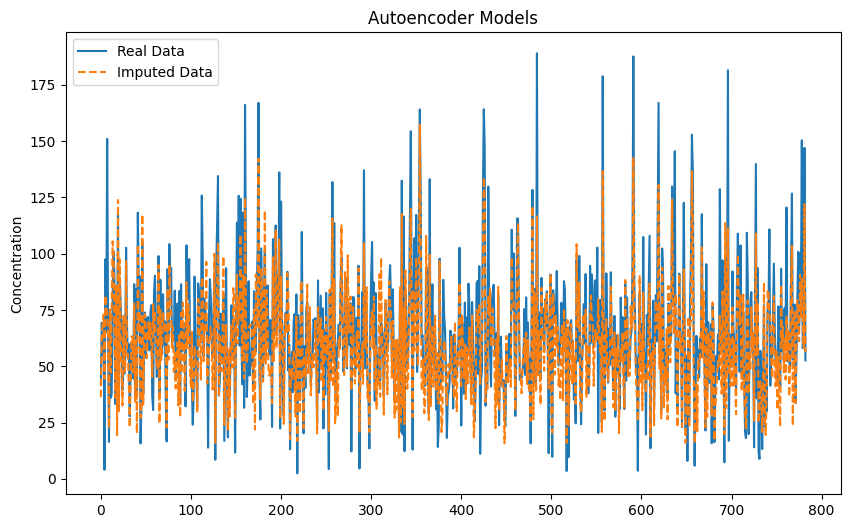

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test['Concentration'], label='Real Data')
plt.plot(predictions_original_scale, label='Imputed Data', linestyle='dashed')
plt.title('Autoencoder Models')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [17]:
data.shape

(3915, 14)